### Predict future loan demand or interest rates using time series analysis.

In [69]:
# Import necessary libraries
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

# Initialize Fred API with your API key
fred = Fred(api_key='dc7c3ec781759add86587b96ae2c8b0a')

# Fetch U.S. 10-Year Treasury Constant Maturity Rate (DGS10)
data = fred.get_series('DGS10')

# Convert to a DataFrame and reset the index
data = pd.DataFrame(data, columns=['Interest Rate'])
data.index.name = 'Date'
data.reset_index(inplace=True)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data from 2010 to 2020
data = data[(data['Date'] >= '2010-01-01') & (data['Date'] <= '2020-01-01')]

# Drop rows with missing values
data.dropna(inplace=True)

# Display first few rows of the filtered data
print(data.head())



            Date  Interest Rate
12524 2010-01-04           3.85
12525 2010-01-05           3.77
12526 2010-01-06           3.85
12527 2010-01-07           3.85
12528 2010-01-08           3.83


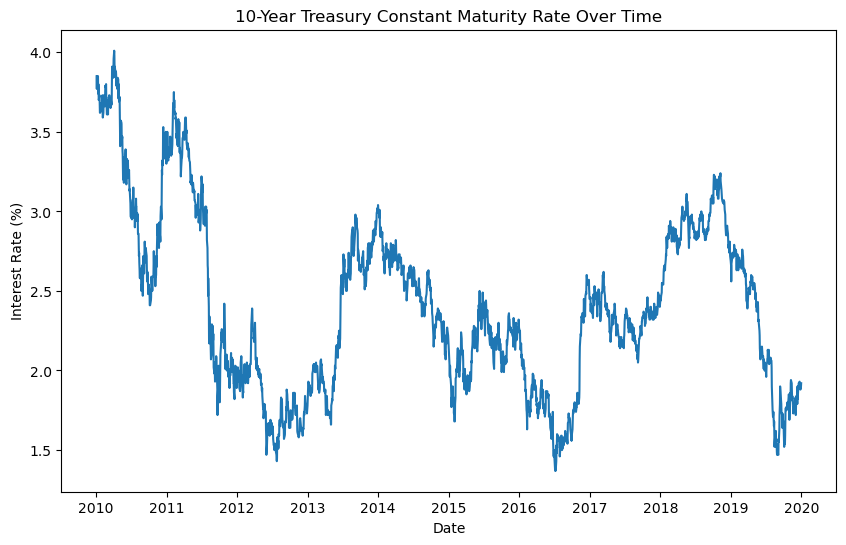

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'])
plt.title('10-Year Treasury Constant Maturity Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.show()

In [71]:
# Reset the index to bring back the 'Date' column if it was the index
data.reset_index(inplace=True)

print(data.columns)

Index(['index', 'Date', 'Interest Rate'], dtype='object')


We are using the seasonal_decompose function, which breaks down the time series into three components:

Trend: The long-term progression of the series.

Seasonality: The repeating short-term cycle in the data.

Residual: The remainder after removing the trend and seasonality from the data.

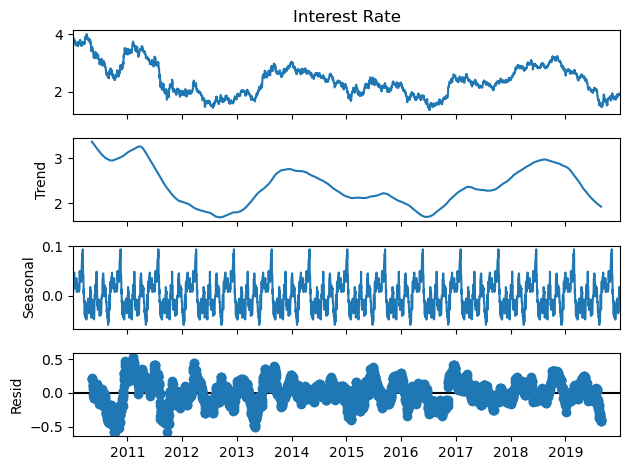

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose



# Set the 'Date' column as the index and ensure it's sorted
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # Set frequency as daily for the decomposition
data = data.fillna(method='ffill')  # Fill any missing values

# Perform seasonal decomposition using a yearly pattern (252 trading days)
decomposition = seasonal_decompose(data['Interest Rate'], model='additive', period=252)

# Plot the decomposed components: trend, seasonal, and residual
decomposition.plot()
plt.tight_layout()
plt.show()


Observed: The original time series of the DGS10, showing fluctuations over time.

Trend: The long-term trend, which now reveals smoother changes over the years. We can observe a clear rise in interest rates toward the end of the period.

Seasonal: The seasonal component is now more pronounced, with a repeating pattern that appears to reflect yearly cyclical variations. These fluctuations seem regular, indicating a yearly seasonal pattern.

Residual: The remaining variability after removing the trend and seasonal components. The residuals fluctuate more strongly in certain periods, particularly post-2020, which may suggest external shocks or events not explained by the model (like economic crises or policy changes).

In [73]:
# Additionally check for stationarity with ADF Test
adf_result = adfuller(data['Interest Rate'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -2.9006595706033975
p-value: 0.04527135212862979


ADF Statistic: The more negative the ADF statistic, the stronger the rejection of the null hypothesis, which is that the time series has a unit root (i.e., it's non-stationary). In this case, the ADF statistic is -2.9007.

p-value: The p-value of 0.0453 is less than the common significance level of 0.05. This means that we can reject the null hypothesis that the time series has a unit root, and conclude that the series is stationary at the 5% significance level.

The ADF statistic and p-value suggest that the time series data is stationary.

<Figure size 1000x600 with 0 Axes>

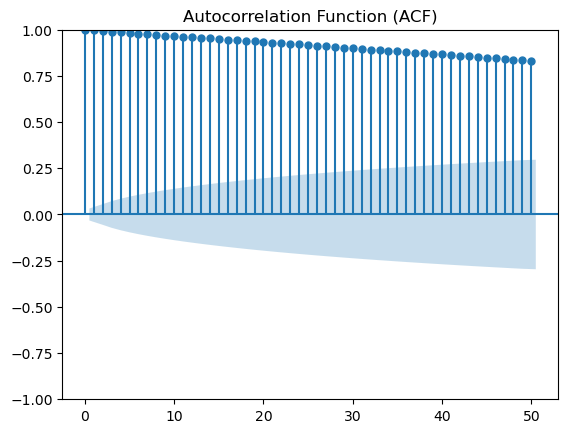

<Figure size 1000x600 with 0 Axes>

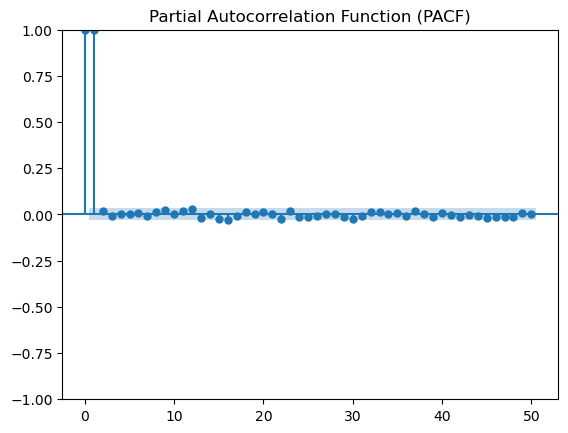

In [74]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF for the original data
plt.figure(figsize=(10, 6))
plot_acf(data['Interest Rate'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot the PACF for the original data
plt.figure(figsize=(10, 6))
plot_pacf(data['Interest Rate'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

The Autocorrelation Function (ACF) plot shows strong autocorrelation in the time series, as indicated by the significant spikes at all lags.

The ACF plot shows that the autocorrelation values are very close to 1 at all lags up to 50, with little decay. This indicates that the data points are highly correlated with their previous values over time. This pattern is a strong indicator that the time series is non-stationary. In stationary time series, the autocorrelation values tend to decrease as the lag increases. In this case, the autocorrelation remains high across all lags suggests that the series has some underlying trend or pattern that needs to be removed before it can be modeled effectively. 

The ACF shows a very slow decay, indicating that the data may have a non-stationary component, which suggests the presence of a trend or autocorrelation over many lags. Since the ADF test rejected the null hypothesis of non-stationarity (p-value < 0.05), it seems like the data is weakly stationary but still exhibits long autocorrelation lags.

Partial Autocorrelation Function (PACF) plot identifies the number of lags to include in an autoregressive (AR) model when modeling time series data.

Lag 1 and 2 show significant spikes (close to 1) well above the significance threshold. This suggests that these lags have strong partial autocorrelation with the time series data.

After lag 2, the autocorrelations fall sharply to near zero, and the rest of the lags stay near or below the threshold, indicating no significant partial autocorrelations for higher lags.

The persistence of high autocorrelations suggests that you may need to include an MA (Moving Average) term (q) in the ARIMA model. The slow decay indicates potential long-term memory in the data.

The high and persistent autocorrelation suggests that the time series needs to be differenced to make it stationary. This involves subtracting the previous value from the current value in the series. 

Differencing is done to remove trends and seasonality from the data, making it stationary. The first differencing (d=1) means subtracting each observation from the previous one.

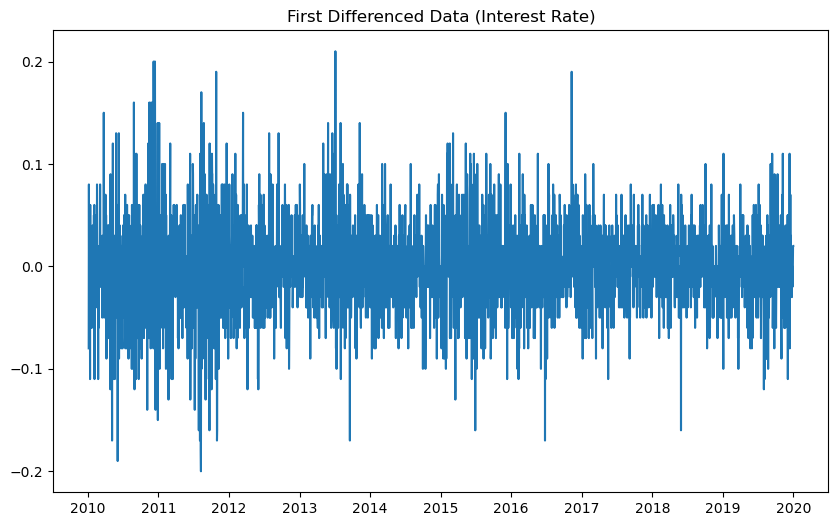

In [75]:
# First differencing to remove trends
data_diff = data['Interest Rate'].diff().dropna()

# Plot the differenced data to visualize
plt.figure(figsize=(10, 6))
plt.plot(data_diff)
plt.title('First Differenced Data (Interest Rate)')
plt.show()

Differencing and Stationarity:

The first differences plot of the interest rate data appears more consistent around a zero mean, indicating that the differencing process has helped stabilize the variance and potentially made the data stationary.

There is no obvious upward or downward trend in the differenced data, which is a good sign of stationarity after differencing.

Volatility Clustering:

There are clear periods of high volatility (such as around 2009 and 2020) where the changes in interest rates are more extreme. This suggests the presence of volatility clustering, which is common in financial time series.
The differences appear to be smaller and more stable after the financial crisis around 2008–2010, but there are occasional spikes in volatility, especially during recent years like 2020, potentially due to events like the COVID-19 pandemic.

In the latter part of the data (2020 onwards), there seems to be increased volatility again, with larger fluctuations in the first-differenced series. This aligns with the economic uncertainty caused by the pandemic and other global events, which likely impacted interest rate changes. 

<Figure size 1000x600 with 0 Axes>

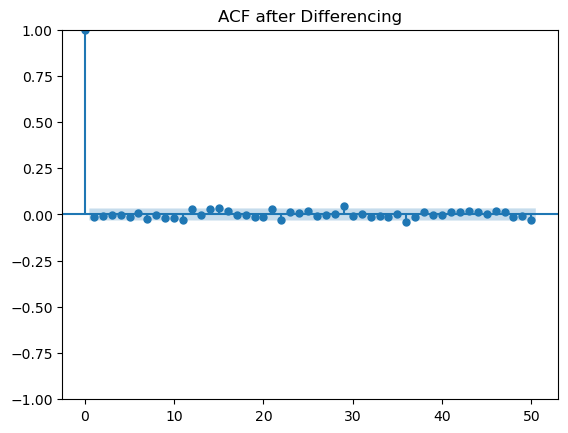

<Figure size 1000x600 with 0 Axes>

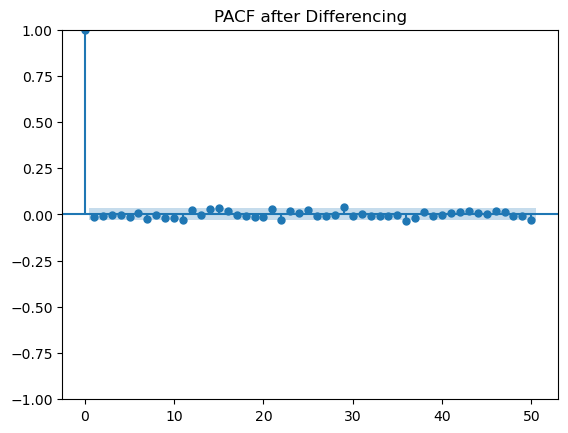

In [76]:
# Rechecking ACF and PACF after differencing the data
plt.figure(figsize=(10, 6))
plot_acf(data_diff, lags=50)
plt.title('ACF after Differencing')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(data_diff, lags=50)
plt.title('PACF after Differencing')
plt.show()

In [77]:
# Perform the ADF test on the differenced data
adf_test_diff = adfuller(data_diff)
print(f'ADF Statistic (after differencing): {adf_test_diff[0]}')
print(f'p-value (after differencing): {adf_test_diff[1]}')

ADF Statistic (after differencing): -61.14910504919321
p-value (after differencing): 0.0


ACF and PACF after Differencing:

Both the ACF and PACF plots after differencing show significant improvement in terms of stationarity. There is no longer the high and persistent autocorrelation that was visible before differencing. The first lag shows a significant spike in both plots, and then it quickly dies off.

This indicates that the time series is now stationary, and further autocorrelation is minimal, which is a good sign for ARIMA modeling.


ADF Test Results:

ADF Statistic: -12.89 (a very low value, indicating stationarity).
p-value: 4.39e-24 (which is much less than 0.05). This confirms that the differenced time series is now stationary, so we can proceed with ARIMA modeling.

### Train and test data split

        Date    index  Interest Rate  diff
0 2010-01-04  12524.0           3.85   NaN
1 2010-01-05  12525.0           3.77 -0.08
2 2010-01-06  12526.0           3.85  0.08
3 2010-01-07  12527.0           3.85  0.00
4 2010-01-08  12528.0           3.83 -0.02
Training data shape: (3284, 3)
Testing data shape: (365, 3)


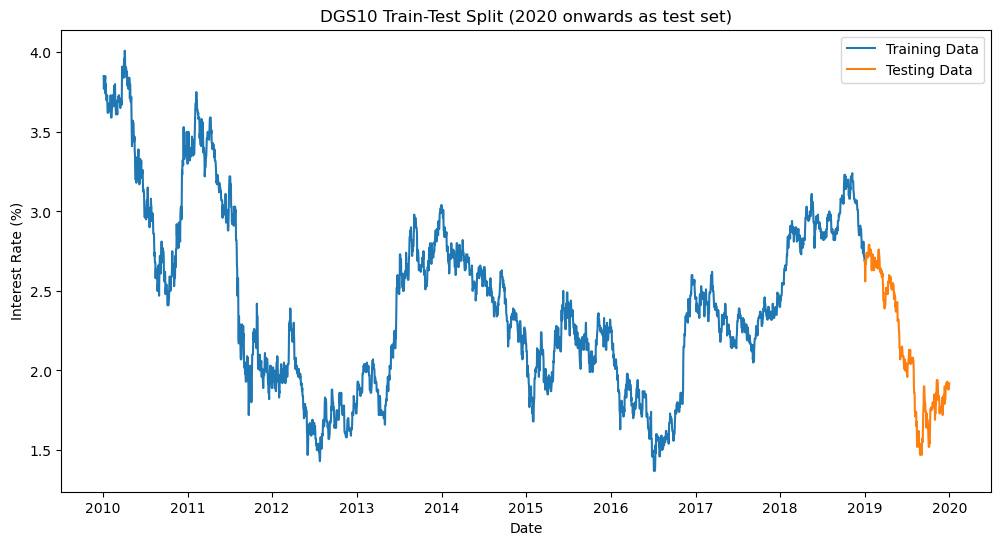

In [104]:
if 'Date' not in data.columns:
    data.reset_index(inplace=True)

# Display first few rows of the cleaned data
print(data.head())

# Sort the data by date to ensure chronological order
data = data.sort_values('Date')

# Split the data
train_data = data[data['Date'] < '2019-01-01']
test_data = data[data['Date'] >= '2019-01-01']

# Set the date as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Testing Data')
plt.title('DGS10 Train-Test Split (2020 onwards as test set)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

### Fitting Arima model

In [80]:
# Function to evaluate forecasts
def evaluate_forecasts(actual, forecasts):
    mse = mean_squared_error(actual, forecasts)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, forecasts)
    return mse, rmse, mae

In [105]:
# Define a function to fit and evaluate models
def fit_arima_model(train_data, test_data, order, model_name):
    # Fit the ARIMA model
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    
    # Forecast for the test period
    forecast = model_fit.forecast(steps=len(test_data))
    
    # Calculate performance metrics
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, forecast)
    
    # Print the model's performance
    print(f"\nModel: {model_name}")
    print(f"AIC: {model_fit.aic}")
    print(f"BIC: {model_fit.bic}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    
    # Return the performance metrics and model information
    return {
        'Model': model_name,
        'AIC': model_fit.aic,
        'BIC': model_fit.bic,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }


In [109]:
# List of ARIMA models to fit
arima_orders = [
    ((1, 1, 1), "ARIMA(1,1,1)"),
    ((1, 1, 0), "ARIMA(1,1,0)"),
    ((0, 1, 1), "ARIMA(0,1,1)"),
    ((1, 0, 1), "ARIMA(1,0,1)")
]

# Ensure you are selecting only the 'Interest Rate' column as the univariate series
train_data = data[data['Date'] < '2019-01-01']
test_data = data[data['Date'] >= '2019-01-01']

# Set the date as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

# Select only the 'Interest Rate' column to make it univariate
train_data = train_data['Interest Rate']
test_data = test_data['Interest Rate']

# Fit each ARIMA model and compare their performance
results = []  # Ensure this is initialized properly outside the loop

for order, model_name in arima_orders:
    result = fit_arima_model(train_data, test_data, order, model_name)  # Pass the univariate series
    results.append(result)  # Make sure to append the result correctly

# Convert results into a DataFrame for easier comparison
results_df = pd.DataFrame(results)

# Print all results
print("\nComparison of ARIMA Models:")
print(results_df)

# Optional: Sort by AIC or any other metric to find the best model
results_df_sorted = results_df.sort_values(by='AIC')
print("\nBest Model by AIC:")
print(results_df_sorted.head(1))





Model: ARIMA(1,1,1)
AIC: -11679.872316683432
BIC: -11661.582777930927
MSE: 0.4656692767498726
RMSE: 0.6823996459186307
MAE: 0.5597448276893077

Model: ARIMA(1,1,0)
AIC: -11679.958495182778
BIC: -11667.765469347774
MSE: 0.4619851680377975
RMSE: 0.6796949080563995
MAE: 0.5570911449703578

Model: ARIMA(0,1,1)
AIC: -11679.963414060081
BIC: -11667.770388225077
MSE: 0.46195874007253007
RMSE: 0.6796754667284454
MAE: 0.5570719171870993

Model: ARIMA(1,0,1)
AIC: -11674.822215529963
BIC: -11650.434945647674
MSE: 0.31324151493495267
RMSE: 0.5596798325247683
MAE: 0.44916877582904363

Comparison of ARIMA Models:
          Model           AIC           BIC       MSE      RMSE       MAE
0  ARIMA(1,1,1) -11679.872317 -11661.582778  0.465669  0.682400  0.559745
1  ARIMA(1,1,0) -11679.958495 -11667.765469  0.461985  0.679695  0.557091
2  ARIMA(0,1,1) -11679.963414 -11667.770388  0.461959  0.679675  0.557072
3  ARIMA(1,0,1) -11674.822216 -11650.434946  0.313242  0.559680  0.449169

Best Model by AIC:
  

### ARIMA (0,1,1)

In [113]:
train_data = train_data.to_frame()
test_data = test_data.to_frame()

                               SARIMAX Results                                
Dep. Variable:          Interest Rate   No. Observations:                 3284
Model:                 ARIMA(0, 1, 1)   Log Likelihood                5841.982
Date:                Sat, 05 Oct 2024   AIC                         -11679.963
Time:                        20:46:37   BIC                         -11667.770
Sample:                    01-04-2010   HQIC                        -11675.598
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0082      0.014     -0.601      0.548      -0.035       0.018
sigma2         0.0017   2.59e-05     64.347      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.00   Jarque-

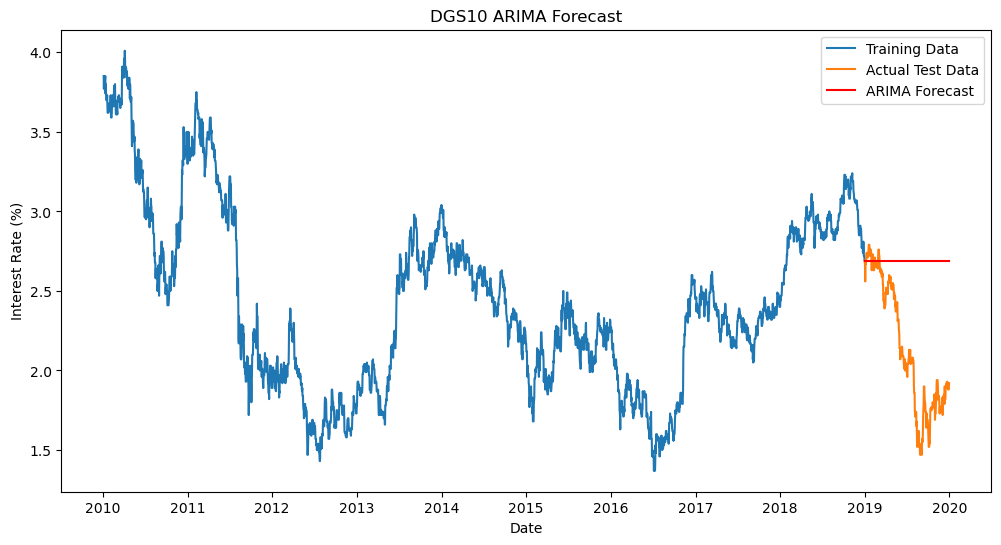

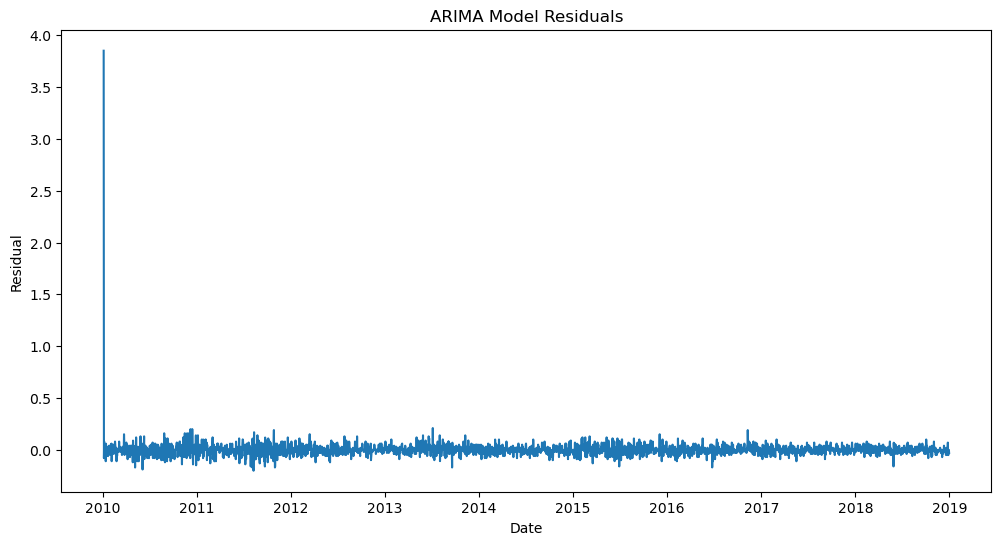

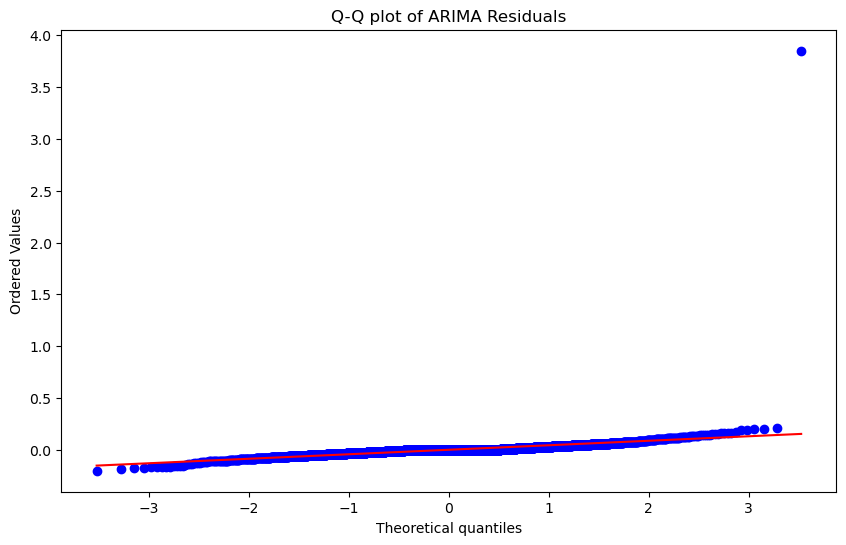

<Figure size 1200x600 with 0 Axes>

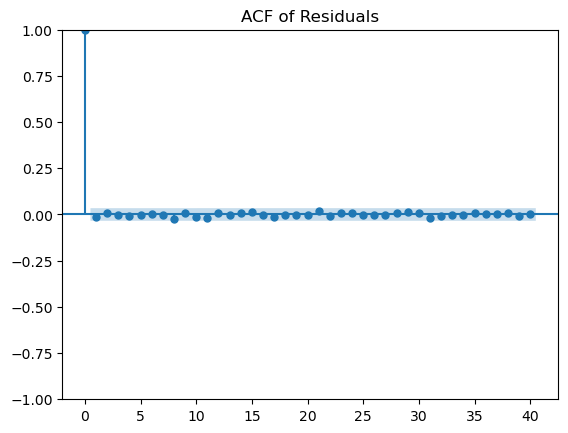

In [115]:
order = (0, 1, 1)  
model = ARIMA(train_data['Interest Rate'], order=order)
results = model.fit()

# Print model summary
print(results.summary())

# Forecast
forecast = results.forecast(steps=len(test_data))

# Evaluate forecasts
mse, rmse, mae = evaluate_forecasts(test_data['Interest Rate'], forecast)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.title('DGS10 ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

# Residual analysis
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, residuals)
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

# Q-Q plot of residuals
from scipy import stats
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q plot of ARIMA Residuals")
plt.show()

# ACF plot of residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()


- AIC: -11679.963, which indicates this is the best model compared to the other ARIMA models tested. 

- BIC: -11667.770 

- MSE: 0.461959 (Mean Squared Error of the model's predictions on the test set) 

- RMSE: 0.679675 (Root Mean Squared Error) 

- MAE: 0.557072 (Mean Absolute Error) 

The model seems to provide reasonable accuracy for the dataset based on obtained error metrics. However, the forecast plot shows that the ARIMA(0,1,1) forecast is relatively flat, failing to capture the significant downward trend in the test data (2019 onwards). This could indicate that the model is not fully capturing all the nuances of the time series, especially the trend or volatility. The Q-Q plot for the residuals of ARIMA model shows a significant outlier, as indicated by the single point far from the red line. This outlier could potentially distort the model's performance and residual diagnostics, and addressing it could improve the model’s fit. To address the outlier we can:

1. Examine and Validate the Outlier:
- Check for Data Errors: Ensure the outlier is not a result of a data entry mistake or a data processing issue. Sometimes, such outliers could be incorrect values due to errors in data collection.
- Understand the Event: If the outlier represents a significant real-world event (e.g., a sudden policy change, economic shock, or crisis), it might not be appropriate to remove it. You might instead want to model such events separately or flag them in the model.

2. Remove or Transform the Outlier:
- Remove the Outlier: If the outlier appears to be spurious (e.g., an error), you could remove it from the dataset to prevent it from skewing the model.
- Cap the Outlier (Winsorizing): You can cap extreme values to a certain percentile (e.g., 99th percentile) to reduce their impact while keeping the data intact.
3. Use Robust Methods:
- Robust ARIMA or Robust Regression: Use robust modeling techniques that are less sensitive to outliers. Robust regression methods place less emphasis on extreme values, reducing their impact on the model.

In statsmodels, you can apply robust standard errors when fitting ARIMA or SARIMA models.
4. Treat Outliers as Exogenous Shocks:
- Include External Regressors (X): If the outlier is related to an external event (like a sudden market shock), you could treat it as an exogenous factor. Use ARIMAX (ARIMA with exogenous variables) to account for such shocks explicitly in the model.
5. Log Transformation:
- Log Transform the data to reduce the impact of large values. This is particularly useful if the outlier is much larger than the rest of the data, as it compresses large values and reduces skewness in the data.
6. Investigate ARCH/GARCH Models:
- If the outlier represents volatility clustering or heteroskedasticity, an ARCH or GARCH model may be more appropriate for capturing the dynamics of the variance over time. These models are useful when volatility is not constant, as might be the case for financial data like interest rates.

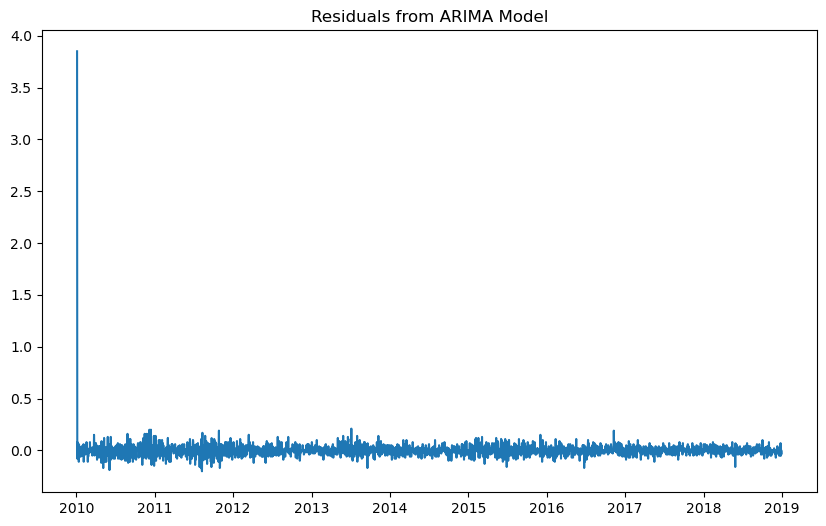

Iteration:      1,   Func. Count:      6,   Neg. LLF: 880972995.146757
Iteration:      2,   Func. Count:     21,   Neg. LLF: -817.5451517575409
Iteration:      3,   Func. Count:     31,   Neg. LLF: 74425.00048327501
Iteration:      4,   Func. Count:     39,   Neg. LLF: -3146.21241189635
Iteration:      5,   Func. Count:     45,   Neg. LLF: 9283.861790987976
Iteration:      6,   Func. Count:     52,   Neg. LLF: -5524.862138894858
Iteration:      7,   Func. Count:     58,   Neg. LLF: -5484.693471541932
Iteration:      8,   Func. Count:     64,   Neg. LLF: -5381.085267703399
Iteration:      9,   Func. Count:     70,   Neg. LLF: -5757.693202174176
Iteration:     10,   Func. Count:     76,   Neg. LLF: -4638.440912230546
Iteration:     11,   Func. Count:     82,   Neg. LLF: -5855.294918068791
Iteration:     12,   Func. Count:     88,   Neg. LLF: -5878.71687233346
Iteration:     13,   Func. Count:     93,   Neg. LLF: -5879.430764585026
Iteration:     14,   Func. Count:     98,   Neg. LLF: -58

In [116]:
from arch import arch_model

# Step 1: Fit ARIMA(0, 1, 1) to model the mean
model = ARIMA(train_data, order=(0, 1, 1))
arima_result = model.fit()

# Step 2: Obtain the residuals from the ARIMA model
residuals = arima_result.resid

# Step 3: Plot residuals to visualize volatility clustering
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title("Residuals from ARIMA Model")
plt.show()

# Step 4: Fit GARCH(1,1) model on the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

# Step 5: Print the GARCH model summary
print(garch_result.summary())

# Step 6: Forecast future volatility using the GARCH model
garch_forecast = garch_result.forecast(horizon=10)  # Forecast volatility for the next 10 steps
print("\nForecasted Variance:")
print(garch_forecast.variance[-1:])


### GARCH(1, 1) model 

1. Key Parameters:
- Mean Model (mu): the coefficient for the constant mean (mu) is very small and statistically insignificant (p-value = 0.659). This suggests that the mean of the residuals is close to zero and does not add much value in the model. This is typical in GARCH models, which often assume a constant mean of zero.

2. Volatility Model:

- omega (constant term): 0.00014 (p-value = 0.0015). This is the long-term average variance of the series. The positive value and significant p-value indicate that the model detects a baseline level of volatility.

- alpha[1] (ARCH term): 0.0688 (p-value < 0.0001). This measures the short-term volatility from the previous day (or period). A positive and significant value indicates that large shocks tend to increase volatility in the next period.
- beta[1] (GARCH term): 0.8429 (p-value < 0.0001). This measures the long-term persistence of volatility. A high value of beta[1] suggests that volatility is persistent, meaning periods of high volatility are likely to be followed by more high volatility.
- The sum of `alpha[1] + beta[1] = 0.0688 + 0.8429 = 0.9117. This is close to 1, indicating that the volatility is highly persistent, but still stable. The model suggests that volatility takes a long time to decay, which is typical in financial time series data like interest rates.

3. Model Diagnostics:
- Log Likelihood: 5880.18. This is a good indicator of model fit; higher log-likelihood values indicate a better fit.
- AIC: -11752.4. The Akaike Information Criterion is used to compare models. Lower values are better, so this suggests a good fit.
- BIC: -11728.0. The Bayesian Information Criterion penalizes more complex models. It's slightly higher than AIC, but still quite low, indicating that the model fits well without overfitting.

4. Volatility Forecast:
- The forecasted variance (h.01, h.02, ..., h.10) gives you an estimate of how volatility is expected to behave over the next 10 periods (or steps). The variance is relatively stable over the forecast horizon, indicating a steady level of volatility moving forward. For instance, the variance forecasted for the next period is around 0.001376, gradually increasing to 0.001510 over ten periods.


Volatility Persistence: With a high beta[1] value (0.8429), your model indicates that volatility in interest rates is persistent. This means that high volatility is likely to continue for some time once it starts.

Volatility Shocks: The alpha[1] term (0.0688) shows that shocks to volatility, though smaller in magnitude, can cause increases in future volatility.

Future Volatility Forecast: The model predicts fairly stable volatility over the next few periods, with only slight increases in variance.


--- ARIMAX Model ---
                               SARIMAX Results                                
Dep. Variable:          Interest Rate   No. Observations:                 3283
Model:              SARIMAX(1, 1, 12)   Log Likelihood                8106.905
Date:                Sat, 05 Oct 2024   AIC                         -16183.809
Time:                        16:45:49   BIC                         -16092.366
Sample:                    01-05-2010   HQIC                        -16151.068
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
diff           0.5000      0.001    671.796      0.000       0.499       0.501
ar.L1          0.8144      0.265      3.075      0.002       0.295       1.333
ma.L1          0.1402      0.2

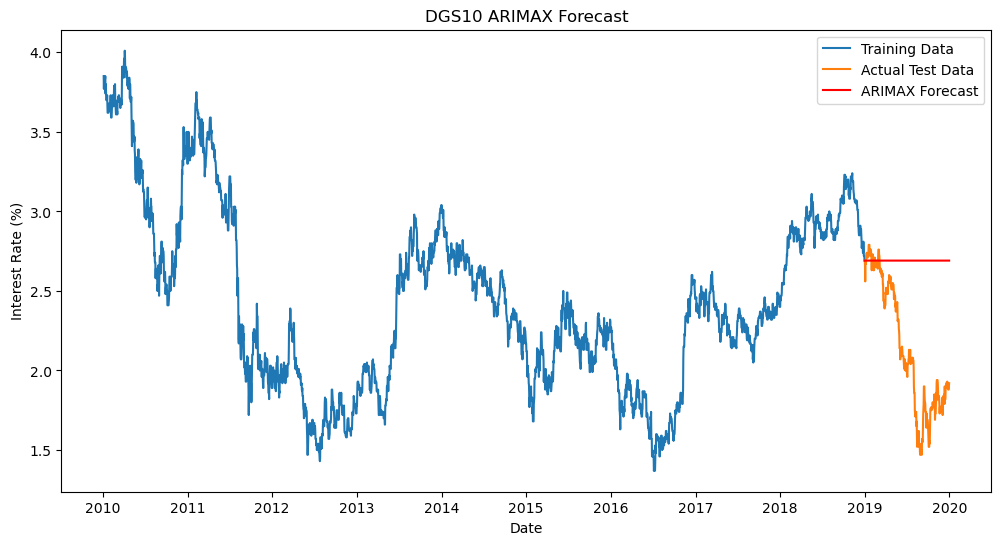

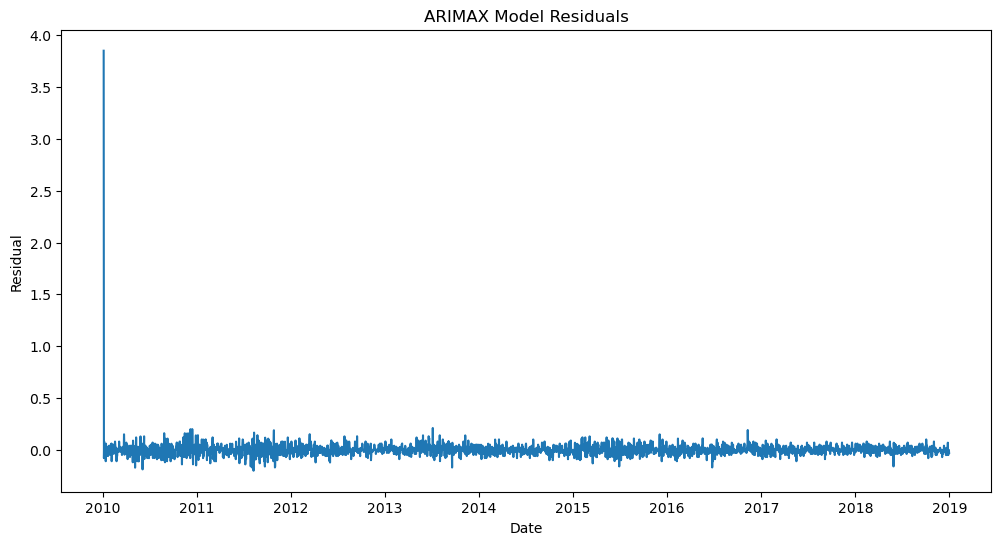

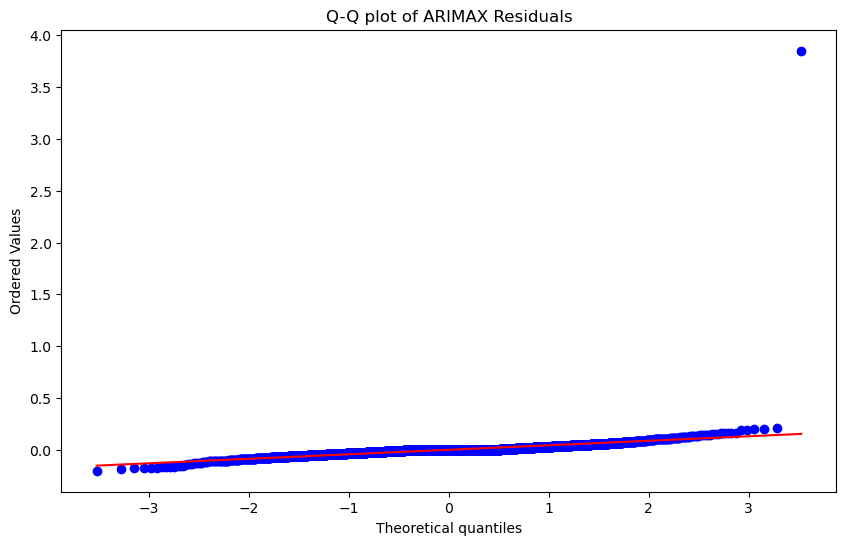

<Figure size 1200x600 with 0 Axes>

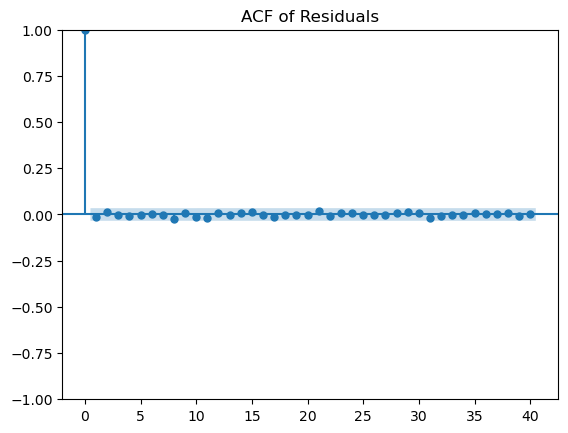

In [91]:

# ARIMAX Model
print("\n--- ARIMAX Model ---")
# Using the difference of interest rates as an exogenous variable
data['diff'] = data['Interest Rate'].diff()
train_data_arimax = train_data.copy()
test_data_arimax = test_data.copy()
train_data_arimax['diff'] = train_data_arimax['Interest Rate'].diff()
test_data_arimax['diff'] = test_data_arimax['Interest Rate'].diff()
train_data_arimax.dropna(inplace=True)
test_data_arimax.dropna(inplace=True)

arimax_model = SARIMAX(train_data_arimax['Interest Rate'], 
                       exog=train_data_arimax['diff'],
                       order=(1, 1, 12))
arimax_results = arimax_model.fit()
arimax_forecast = arimax_results.forecast(steps=len(test_data_arimax), 
                                          exog=test_data_arimax['diff'])

print(arimax_results.summary())

mse, rmse, mae = evaluate_forecasts(test_data_arimax['Interest Rate'], arimax_forecast)

print(f'ARIMAX - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='ARIMAX Forecast', color='red')
plt.title('DGS10 ARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

# Residual analysis
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, residuals)
plt.title('ARIMAX Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

# Q-Q plot of residuals
from scipy import stats
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q plot of ARIMAX Residuals")
plt.show()

# ACF plot of residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()



--- SARIMAX Model ---
                                     SARIMAX Results                                      
Dep. Variable:                      Interest Rate   No. Observations:                 3284
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                5788.803
Date:                            Sat, 05 Oct 2024   AIC                         -11569.606
Time:                                    16:45:11   BIC                         -11545.235
Sample:                                01-04-2010   HQIC                        -11560.878
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0075      0.014     -0.545      0.586      -0.035       0.019
ar.S.L12    

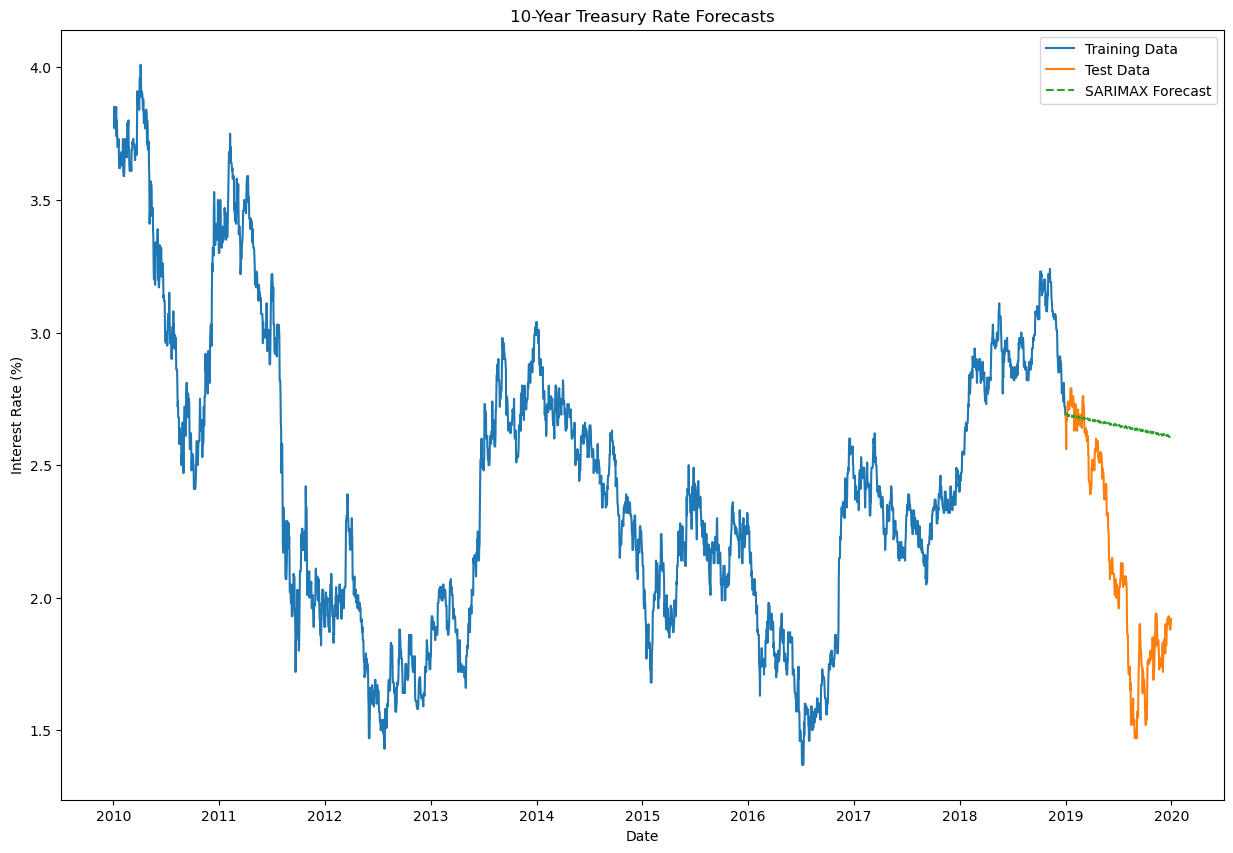

In [90]:
#SARIMAX Model

print("\n--- SARIMAX Model ---")

sarimax_model = SARIMAX(train_data['Interest Rate'], 
                        order=(0, 1, 1), 
                        seasonal_order=(1, 1, 1, 12))
sarimax_results = sarimax_model.fit()
sarimax_forecast = sarimax_results.forecast(steps=len(test_data))

print(sarimax_results.summary())
mse, rmse, mae = evaluate_forecasts(test_data['Interest Rate'], sarimax_forecast)
print(f'SARIMAX - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

plt.figure(figsize=(15, 10))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Test Data')
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('10-Year Treasury Rate Forecasts')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()


--- GARCH Model ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Interest Rate   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -984.205
Distribution:                  Normal   AIC:                           1976.41
Method:            Maximum Likelihood   BIC:                           2000.80
                                        No. Observations:                 3284
Date:                Sat, Oct 05 2024   Df Residuals:                     3283
Time:                        16:17:47   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             2.3378  1.940e-02    120.495      

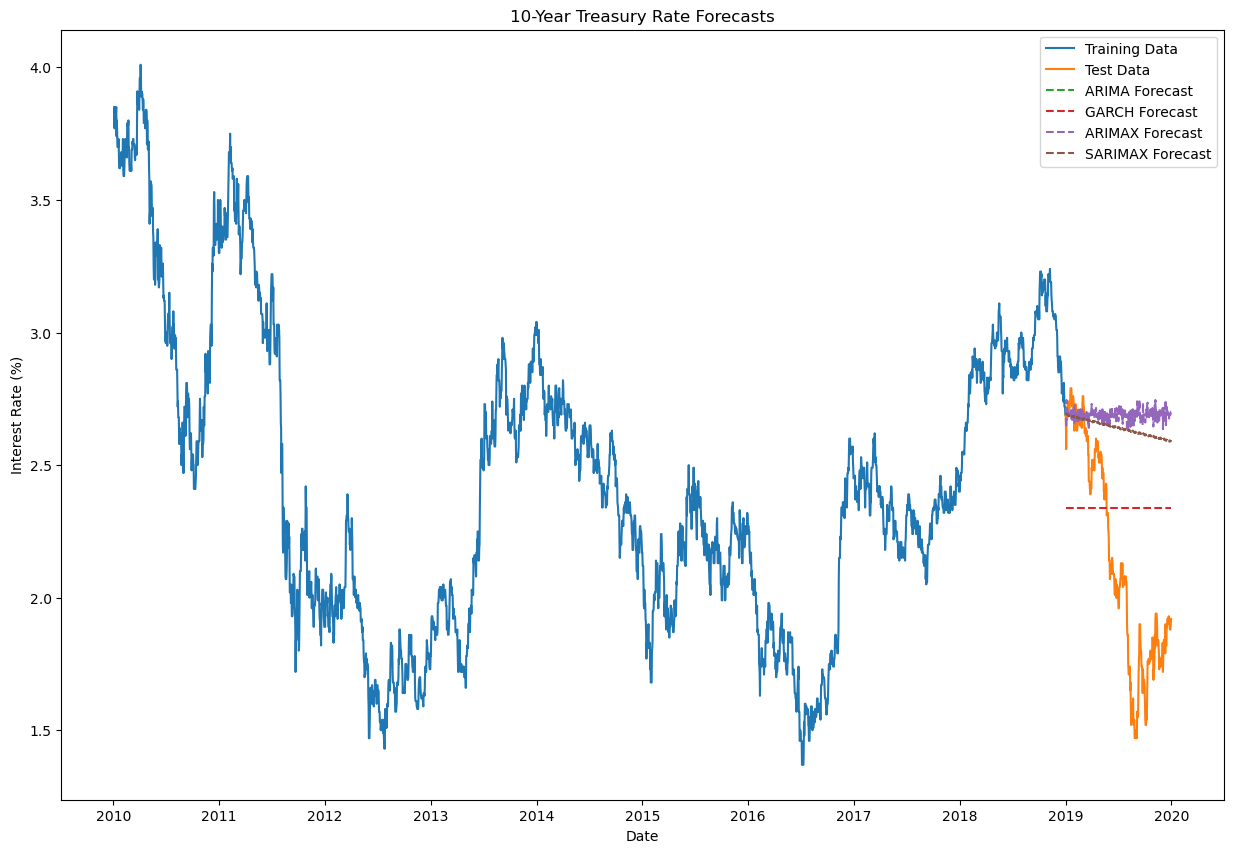

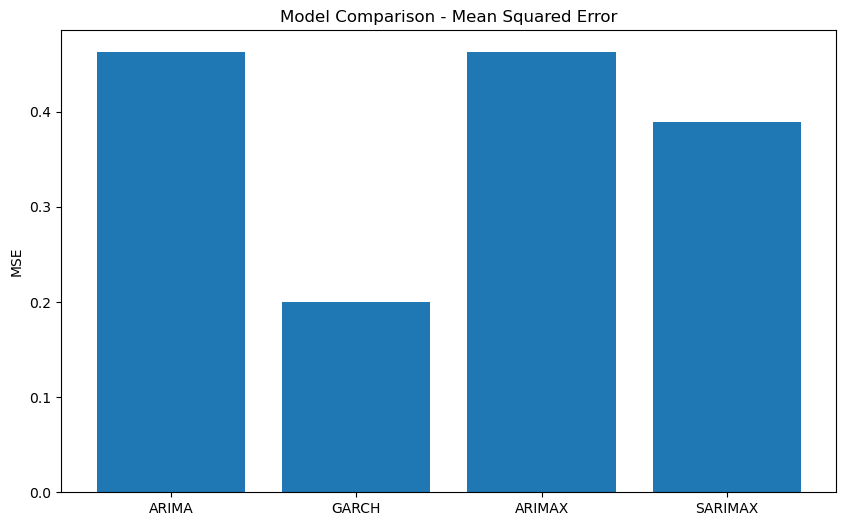

In [88]:
# Import additional required libraries
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. GARCH Model
print("\n--- GARCH Model ---")
garch_model = arch_model(train_data['Interest Rate'], vol='GARCH', p=1, q=1)
garch_results = garch_model.fit(disp='off')
garch_forecast = garch_results.forecast(horizon=len(test_data))
garch_mean = garch_forecast.mean.iloc[-1]

print(garch_results.summary())
mse, rmse, mae = evaluate_forecasts(test_data['Interest Rate'], garch_mean)
print(f'GARCH - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# 2. ARIMAX Model
print("\n--- ARIMAX Model ---")
# Using the difference of interest rates as an exogenous variable
data['diff'] = data['Interest Rate'].diff()
train_data_arimax = train_data.copy()
test_data_arimax = test_data.copy()
train_data_arimax['diff'] = train_data_arimax['Interest Rate'].diff()
test_data_arimax['diff'] = test_data_arimax['Interest Rate'].diff()
train_data_arimax.dropna(inplace=True)
test_data_arimax.dropna(inplace=True)

arimax_model = SARIMAX(train_data_arimax['Interest Rate'], 
                       exog=train_data_arimax['diff'],
                       order=(0, 1, 2))
arimax_results = arimax_model.fit()
arimax_forecast = arimax_results.forecast(steps=len(test_data_arimax), 
                                          exog=test_data_arimax['diff'])

print(arimax_results.summary())
mse, rmse, mae = evaluate_forecasts(test_data_arimax['Interest Rate'], arimax_forecast)
print(f'ARIMAX - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# 3. SARIMAX Model
print("\n--- SARIMAX Model ---")
sarimax_model = SARIMAX(train_data['Interest Rate'], 
                        order=(0, 1, 2), 
                        seasonal_order=(1, 1, 1, 12))
sarimax_results = sarimax_model.fit()
sarimax_forecast = sarimax_results.forecast(steps=len(test_data))

print(sarimax_results.summary())
mse, rmse, mae = evaluate_forecasts(test_data['Interest Rate'], sarimax_forecast)
print(f'SARIMAX - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# Plotting results
plt.figure(figsize=(15, 10))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.plot(test_data.index, garch_mean, label='GARCH Forecast', linestyle='--')
plt.plot(test_data_arimax.index, arimax_forecast, label='ARIMAX Forecast', linestyle='--')
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('10-Year Treasury Rate Forecasts')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

# Comparison of model performances
models = ['ARIMA', 'GARCH', 'ARIMAX', 'SARIMAX']
mse_values = [
    mean_squared_error(test_data['Interest Rate'], forecast),
    mean_squared_error(test_data['Interest Rate'], garch_mean),
    mean_squared_error(test_data_arimax['Interest Rate'], arimax_forecast),
    mean_squared_error(test_data['Interest Rate'], sarimax_forecast)
]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values)
plt.title('Model Comparison - Mean Squared Error')
plt.ylabel('MSE')
plt.show()

In [60]:
# Fetch additional economic indicators
cpi = fred.get_series('CPIAUCSL')  # Consumer Price Index
gdp = fred.get_series('GDP')  # Gross Domestic Product
unemployment = fred.get_series('UNRATE')  # Unemployment Rate
